## Analysing model training

In [166]:
import util
from importlib import reload
reload(util)

<module 'util' from '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/util.py'>

In [2]:
import torch
import os
import h5py
import sympy as sp
from util import data2input, prods_to_eq, plot_onehot, load_raw_parsed_value_data
from grammar import GCFG

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, data_syntax, values = load_raw_parsed_value_data(datapath=datapath, name='expr_240807_5')

model_path = os.path.abspath('/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/checkpoints/model_240808_5_5epoch.pt')
vae_model = torch.load(model_path)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(vae_model)
print(f"Total trainable parameters: {total_params}")

# Breakdown by component
encoder_params = count_parameters(vae_model.encoder)
decoder_params = count_parameters(vae_model.decoder)
value_decoder_params = count_parameters(vae_model.value_decoder)

print(f"Encoder parameters: {encoder_params}")
print(f"Decoder parameters: {decoder_params}")
print(f"Value Decoder parameters: {value_decoder_params}")


Total trainable parameters: 26157
Encoder parameters: 989
Decoder parameters: 3692
Value Decoder parameters: 21476


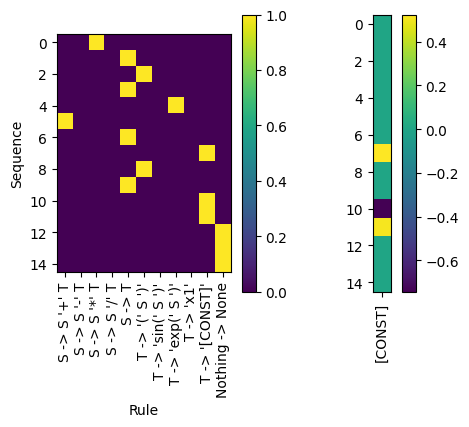

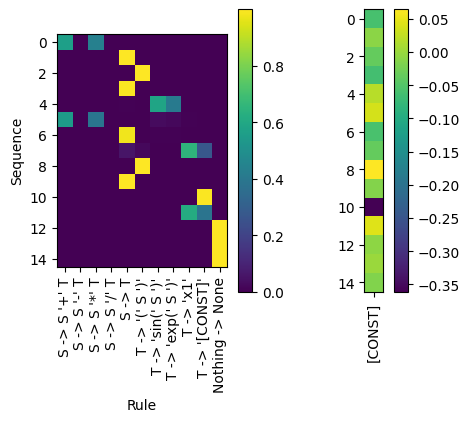

In [36]:
i = 100
x = data2input(data_syntax[i, ...])

logits, values_pred = vae_model.forward(x)

plot_onehot(x.squeeze(0).T.detach().numpy(), GCFG, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), GCFG, apply_softmax=True, figsize=(5, 4))

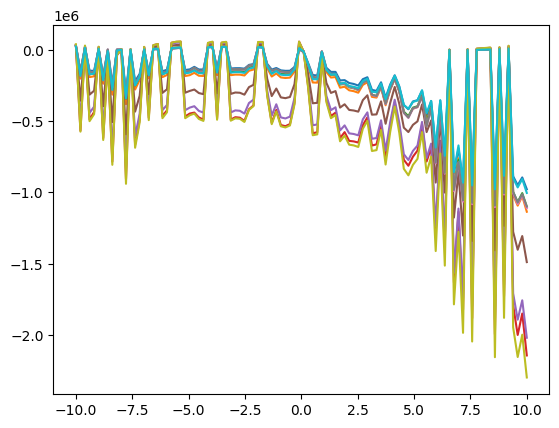

In [40]:
from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)

for _ in range(10):
    z = torch.randn(1, 3)
    res = vae_model.value_decoder.forward(z)
    plt.plot(x, res.squeeze().detach().numpy())
plt.show()

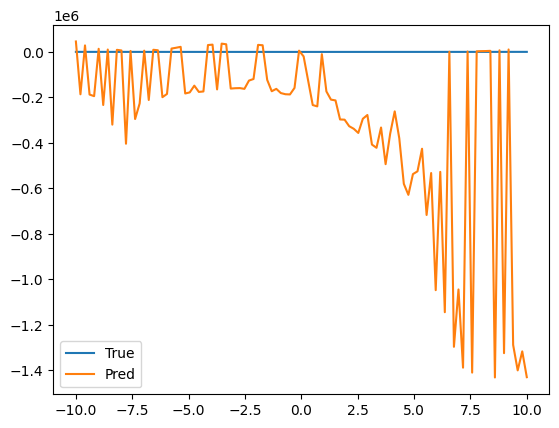

In [46]:
from matplotlib import pyplot as plt
import numpy as np

i = 1000
x = data2input(data_syntax[i, ...])

logits, values_pred = vae_model.forward(x)

x = np.linspace(-10, 10, 100)

plt.plot(x, values[i, :].squeeze(), label='True')
plt.plot(x, values_pred.squeeze().detach().numpy(), label='Pred')
plt.legend()
plt.show()

In [129]:
mu, sigma

(tensor([[ 0.1684, -1.4036]], grad_fn=<AddmmBackward0>),
 tensor([[5.7642e-16, 8.1407e-15]], grad_fn=<SoftplusBackward0>))

In [155]:
z = vae_model.sample(mu, sigma*1e7)
prods = vae_model.generate(z, sample=False, max_length=15)
expr_str = prods_to_eq(prods, verbose=True)
print(f'{expr_str}; Original:\n{eqs[i]}')

x1 + ( x1 + ( x1 + x1 ) ); Original:
((x1*(-0.2935903072357178))+x1)+(-0.7014608383178711)


In [297]:
from util import load_onehot_data, batch_iter

# Load data
parsed_path = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/onehot_parsed.h5'
data = load_onehot_data(parsed_path)
data = torch.from_numpy(data).float()  # .to(model.device)

x, y_rule_idx, y_consts = next(batch_iter(data, 10))

# Turn x from onehot (i.e. probability) into logits
epsilon = 1e-1  # Small value to avoid log(0)
x[:, :-1, :] = torch.log(x[:, :-1, :].clamp(min=epsilon, max=1-epsilon)) - torch.log1p(-x[:, :-1, :].clamp(min=epsilon, max=1-epsilon))

In [132]:
i = 3
eq = eqs[i]

expr = sp.simplify(sp.sympify(eq))
print(f'{eq = }; {expr = }')

x = data2input(data_syntax[i, ...])
mu, sigma = vae_model.encoder(x)
production = vae_model.generate(mu, sample=True, max_length=15)

print(f'{production = }')
eq_hat = prods_to_eq(production, verbose=True)
if eq_hat:
    expr_hat = sp.simplify(sp.sympify(eq_hat))
    print(f'{expr_hat = }')

eq = '(x1 + -0.39264077005823406) * 0.6814422896206572'; expr = 0.6814422896206572*x1 - 0.267562025346901
production = [S -> S '*' T, S -> T, T -> '(' S ')', S -> S '-' T, S -> T, T -> '-7.4198079109191895', T -> 'x1', T -> 'x1']
expr_hat = -x1*(x1 + 7.4198079109191895)


## Value decoder debug

In [11]:
import value_decoder
reload(value_decoder)

from value_decoder import ValueDecoder


vdecoder = ValueDecoder()

decoder_params = sum(p.numel() for p in vdecoder.parameters() if p.requires_grad)
decoder_params

21412

In [5]:
from importlib import reload
import model
import value_decoder
import encoder
import decoder
reload(model)
reload(value_decoder)
reload(encoder)
reload(decoder)
from decoder import Decoder
from encoder import Encoder


from model import GrammarVAE
from grammar import GCFG

ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
MAX_LENGTH = 15
OUTPUT_SIZE = len(GCFG.productions()) + 1

vae_model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE, device='cpu')


decoder_params = sum(p.numel() for p in vae_model.decoder.parameters() if p.requires_grad)
encoder_params = sum(p.numel() for p in vae_model.encoder.parameters() if p.requires_grad)

decoder_params, encoder_params


Initializing Encoder
Type of self: <class 'encoder.Encoder'>
Type of Encoder: <class 'type'>


(3672, 4328)

In [60]:
from importlib import reload
import util
reload(util)

from util import load_raw_parsed_value_data

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, data_syntax, values = load_raw_parsed_value_data(datapath, 'expr_240807_5')

In [69]:
from torch.utils.data import DataLoader, random_split, Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, data_syntax, values):
        assert data_syntax.shape[0] == values.shape[0]
        self.data_syntax = torch.tensor(data_syntax, dtype=torch.float32)
        self.values = torch.tensor(values, dtype=torch.float32)

    def __len__(self):
        return len(self.data_syntax)

    def __getitem__(self, idx):
        x_syn = self.data_syntax[idx, ...].transpose(-2, -1) # new shape [batch, RULE_COUNT+1, SEQ_LEN] as required by model
        # x_syn = Variable(x_syn)
        y_rule_idx = x_syn[:, :-1, ...].argmax(axis=1) # The rule index (argmax over onehot part, excluding consts)
        y_consts = x_syn[:, -1, ...]

        return x_syn, y_rule_idx, y_consts, self.values[idx]

def load_data(datapath: str, name: str):
    eqs, data_syntax, values = load_raw_parsed_value_data(datapath, name)
    # Create the full dataset
    full_dataset = CustomDataset(data_syntax, values)

    # Split the dataset
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Create DataLoaders
    batch_size = 32  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_data(datapath, 'expr_240807_5')

a = next(iter(train_loader))
a[0].shape, a[1].shape, a[2].shape, a[3].shape

(torch.Size([32, 12, 15]),
 torch.Size([32, 12]),
 torch.Size([32, 12]),
 torch.Size([32, 100]))

In [72]:
from util import batch_iter

eqs, data_syntax, data_value = load_raw_parsed_value_data(datapath, 'expr_240807_5')
data_syntax = torch.from_numpy(data_syntax).float()
data_value = torch.from_numpy(data_value).float()


b = next(batch_iter(data_syntax, data_value, 32))
b[0].shape, b[1].shape, b[2].shape, b[3].shape


(torch.Size([32, 12, 15]),
 torch.Size([32, 15]),
 torch.Size([32, 15]),
 torch.Size([32, 100]))

In [78]:
import util
reload(util)

from util import load_data

train_loader, test_loader = load_data(datapath, 'expr_240807_5')

a = next(iter(train_loader))
a[0].shape, a[1].shape, a[2].shape, a[3].shape

(torch.Size([32, 12, 15]),
 torch.Size([32, 15]),
 torch.Size([32, 15]),
 torch.Size([32, 100]))

In [80]:
len(train_loader)

2103

In [14]:
type(best_model)

_io.TextIOWrapper

In [24]:
import torch
import wandb

run = 'argz5vfx'
with wandb.restore('model.pt', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}") as io:
    name = io.name
vae_model = torch.load(name)